In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pylab as pl
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense,Dropout, Activation, Flatten
from tensorflow.keras import layers,activations
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# dataset : https://www.kaggle.com/datasets/eabdul/flying-vehicles
base_dir = "planes"
img_h_size = 256
img_w_size = 256

In [3]:
train_datagen = ImageDataGenerator(
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    zca_epsilon=1e-06,
                                    rotation_range=0,
                                    width_shift_range=0.0,
                                    height_shift_range=0.0,
                                    brightness_range=None,
                                    shear_range=0.0,
                                    zoom_range=0.0,
                                    channel_shift_range=0.0,
                                    fill_mode='nearest',
                                    cval=0.0,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    rescale=1./255, 
                                    preprocessing_function=None,
                                    data_format=None,
                                    validation_split=0.1,
                                    dtype=None)

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.1)

In [4]:
train_data = train_datagen.flow_from_directory(
                                                base_dir,
                                                target_size=(img_h_size,img_w_size),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=8,
                                                shuffle=True,
                                                seed=None,
                                                save_to_dir=None,
                                                save_prefix='',
                                                save_format='png',
                                                follow_links=False,
                                                subset="training",
                                                interpolation='nearest')

test_data = test_datagen.flow_from_directory(
                                                base_dir,
                                                target_size=(img_h_size,img_w_size),
                                                subset="validation",
                                                batch_size=8)

Found 7575 images belonging to 6 classes.
Found 839 images belonging to 6 classes.


In [5]:
## Test yazarken işe yarıyor :)
print("class_indices : ",train_data.class_indices)
print("egitim veri sayısı : ",len(train_data.classes))
print("classes : ",train_data.classes)
print("egitim veri sayısı : ",train_data.samples)
# print("Veri dosya isimleri :",train_datagen.filenames) # ['drone/00000138.jpg', 'drone/00000139.jpg',..
print("interpolasyon türü : ",train_data.interpolation)
print("target size : ",train_data.target_size)
print("subset : ",train_data.subset)
print("Shuffle : ",train_data.shuffle)
print("Split oranı : ",train_data.split)
print("Transfer lea",train_data.sample_weight)

class_indices :  {'drone': 0, 'fighter-jet': 1, 'helicopter': 2, 'missile': 3, 'passenger-plane': 4, 'rocket': 5}
egitim veri sayısı :  7575
classes :  [0 0 0 ... 5 5 5]
egitim veri sayısı :  7575
interpolasyon türü :  nearest
target size :  (256, 256)
subset :  training
Shuffle :  True
Split oranı :  (0.1, 1)
Transfer lea None


In [6]:
classes_name = ["drone", "fighter-jet", "helicopter", "missile", "passenger-plane", "rocket"]

In [7]:
# test_datagen.next() # rastgele data getirir

index no : [0. 0. 0. 0. 1. 0.]
name : passenger-plane


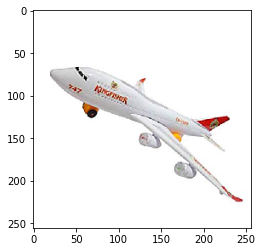

index no : [1. 0. 0. 0. 0. 0.]
name : drone


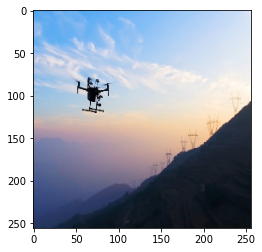

index no : [0. 0. 1. 0. 0. 0.]
name : helicopter


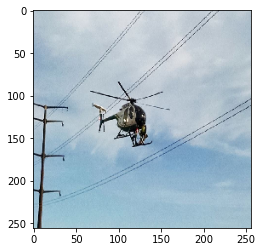

index no : [0. 1. 0. 0. 0. 0.]
name : fighter-jet


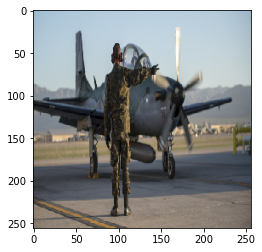

index no : [0. 0. 0. 0. 1. 0.]
name : passenger-plane


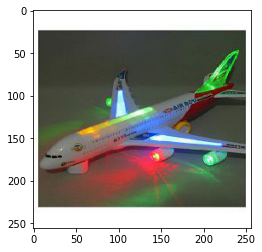

In [8]:
for _ in range(5):
    img,label = test_data.next() 
    plt.imshow(img[0])
    print("index no :",label[0])
    print("name :",classes_name[np.argmax(label[0])])
    plt.show()

In [10]:
model = Sequential()

model.add(layer=Conv2D(filters=4,activation="relu",kernel_size=(5,5),input_shape = (img_h_size,img_w_size,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dense(50,activation="relu")) # 50 nöron gizli katman
model.add(Dropout(0.2))
model.add(layer=Conv2D(filters=8,activation="relu",kernel_size=(5,5)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dense(100,activation="relu")) # 100 nöron gizli katmanda
model.add(Dropout(0.2))
model.add(layer=Conv2D(filters=16,activation="relu",kernel_size=(5,5)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dense(50,activation="relu")) # 50 nöron gizli katmanda
model.add(Dropout(0.2))
model.add(layer=Conv2D(filters=32,activation="relu",kernel_size=(5,5)))
model.add(layers.Flatten())
model.add(layers.Dense(6,activation="softmax")) # sınıf sayısı kadar çıktı alıyoruz
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 252, 252, 4)       304       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 126, 126, 4)      0         
 2D)                                                             
                                                                 
 dense_4 (Dense)             (None, 126, 126, 50)      250       
                                                                 
 dropout_3 (Dropout)         (None, 126, 126, 50)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 8)       10008     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 61, 8)        0         
 2D)                                                  

In [ ]:
tf.config.set_soft_device_placement(True)

optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()

with tf.device("/gpu:0"):
    model.compile(optimizer=optimizer,loss=loss,metrics=["mse","accuracy"])
    result = model.fit(train_data, epochs=10, verbose=1, validation_data=test_data)

Epoch 1/10


2022-05-09 13:31:42.135435: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-09 13:31:42.465565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


947/947 [==============================] - ETA: 0s - loss: 1.7843 - mse: 0.1385 - accuracy: 0.2191

2022-05-09 13:33:29.667033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


947/947 [==============================] - 119s 122ms/step - loss: 1.7843 - mse: 0.1385 - accuracy: 0.2191 - val_loss: 1.7807 - val_mse: 0.1382 - val_accuracy: 0.2193
Epoch 2/10
947/947 [==============================] - 127s 134ms/step - loss: 1.7813 - mse: 0.1383 - accuracy: 0.2190 - val_loss: 1.7799 - val_mse: 0.1382 - val_accuracy: 0.2193
Epoch 3/10
947/947 [==============================] - 128s 136ms/step - loss: 1.7799 - mse: 0.1382 - accuracy: 0.2190 - val_loss: 1.7779 - val_mse: 0.1381 - val_accuracy: 0.2193
Epoch 4/10
947/947 [==============================] - 135s 143ms/step - loss: 1.7757 - mse: 0.1380 - accuracy: 0.2193 - val_loss: 1.7680 - val_mse: 0.1376 - val_accuracy: 0.2205
Epoch 5/10
947/947 [==============================] - 131s 138ms/step - loss: 1.7591 - mse: 0.1371 - accuracy: 0.2304 - val_loss: 1.7163 - val_mse: 0.1347 - val_accuracy: 0.2718
Epoch 6/10
947/947 [==============================] - 132s 139ms/step - loss: 1.7150 - mse: 0.1344 - accuracy: 0.2838 - v

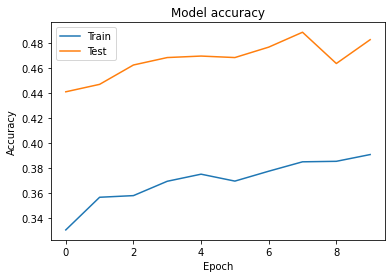

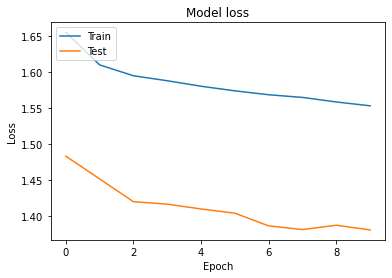

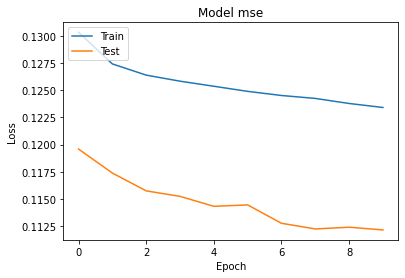

105/105 [==============================] - 9s 89ms/step - loss: 1.3804 - mse: 0.1121 - accuracy: 0.4827
Test loss: 1.3804296255111694
Test accuracy: 0.11214058101177216


In [55]:
#plot accuracy vs epoch
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(model.history.history['mse'])
plt.plot(model.history.history['val_mse'])
plt.title('Model mse')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

### Sonuçlar

---
aktivasyon : elu  
batch_size : 16   
epoch : 5  

53/53 [==============================] - 22s 413ms/step - loss: 1.4363 - mse: 0.1157 - accuracy: 0.4613  
Test loss: 1.4362766742706299  
Test accuracy: 0.11565399914979935
----

aktivasyon : relu  
batch_size : 16  
epoch : 5

53/53 [==============================] - 15s 269ms/step - loss: 1.6430 - mse: 0.1309 - accuracy: 0.3385  
Test loss: 1.642993450164795  
Test accuracy: 0.13085642457008362
---

aktivasyon : relu   
batch_size : 8  
epoch : 5  

105/105 [==============================] - 10s 90ms/step - loss: 1.5722 - mse: 0.1262 - accuracy: 0.3552  
Test loss: 1.5722285509109497  
Test accuracy: 0.12617748975753784  
---

aktivasyon : relu   
batch_size : 8  
epoch : 10    

105/105 [==============================] - 9s 89ms/step - loss: 1.3804 - mse: 0.1121 - accuracy: 0.4827  
Test loss: 1.3804296255111694  
Test accuracy: 0.11214058101177216  
 
---